# HW6 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

In this homework assignment, we're going to implement DP-SGD for neural networks! Recall from the class that classical ML models possessed convenient properties such as Convexity and L-Lipschitzness which make the DP analysis easy. However, modern neural networks, like the one we'll be working with, does not have these properties. Thus, we need to modify the training algorithm, gradient descent, so that the trained model is DP.

## Prerequisites:

Set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Mount Google Drive

Create a folder named `HW6` under `ML_Systems` in your Google drive.

In [1]:
from google.colab import drive

drive.mount("/content/drive")

import sys, os

data_dir = "/content/drive/MyDrive/ML_Systems/HW6/data"

Mounted at /content/drive


## Initial Setup

This section imports all required packages from PyTorch.

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(0)

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Define model architecture and prepare dataset, which are the same as the previous homework.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

In [5]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(
    model: nn.Module, dataloader: DataLoader, max_samples=None
) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0  # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (
                (predicted == labels).sum().item()
            )  # Count correct predictions

            if (
                max_samples
            ):  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[
                    0
                ]  # Increment the count of inferences made
                if (
                    inference_count > max_samples
                ):  # Stop testing if maximum samples reached
                    break

    accuracy = (
        100 * correct_predictions / total_samples
    )  # Calculate the accuracy as a percentage
    return accuracy

## DP Hyperparamters
Here is where we will defined the different hyperparameters needed for DP-SGD.
* $N = 2048$: Number of datapoints we are using. Since DP-SGD takes extremely long to run, we will only use a subset of the total CIFAR-10 dataset
* $C = 1.0$: This is the clipping threshold. If $||∇L(x, y)||_{2} > C$ then we divide by $||∇L(x, y)||_{2}$.
* $E = 20$: Number of epochs to run DP-SGD
* $q = batch\_size / N$: This is the sample probability. Since we are grouping the dataset into batches, each batch can be thought of as being sampled.
* $T = \frac{E}{q}$: number of iterations. This is more of an internal value used to calculate the DP parameter values, because DP-SGD is measured in terms of iterations, not epochs. But we can convert from Epochs to iterations.
* $\sigma$: The noise multiplier used to add noise to the gradients. As $\sigma$ gets larger, the privacy guarantee improves but the variance of the noise increases, which can reduce the accuracy or utility. The choice of $\sigma$ is often related to the desired $\varepsilon$ value; achieving a lower
$\varepsilon$ (stronger privacy) typically requires a higher
$\sigma$.

* $\delta = 10^{-5}$: This is the probability of failure. We will set this to a default value.
* $\varepsilon = \frac{q * \sqrt{T * \log(1 / \delta)}}{\sigma}$: the privacy loss, which is a function of the other hyperparameters. It quantifies the strength of the privacy guarantee. In DP, $\varepsilon$ is used to define the level of indistinguishability that the algorithm ensures between outputs generated from datasets that differ by a single element. A smaller value means  a stronger privacy guarantee, meaning the outputs of the algorithm are more similar (indistinguishable) regardless of whether any individual's data is included or excluded from the dataset.
However, a smaller value usually means more noise must be added to the data, which can degrade the utility or accuracy of the algorithm's output.


In [6]:
batch_size = 32
N = 2048
C = 1.0
E = 20
q = batch_size / N
T = E / q
delta = 1e-5

In [7]:
# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (
    0.5,
    0.5,
    0.5,
)  # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize(mean_values, std_values),  # Normalize tensor values
    ]
)

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform
)

trainsubset = torch.utils.data.Subset(trainset, torch.arange(N))

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(
    trainsubset, batch_size=batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified


## Non-Private Training with SGD

In [8]:

def SGD(model, dataloader, lr):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss

        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")  # Training loop is complete

# Create model and start training
net = Net().to(device)
SGD(net, trainloader, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3020
Epoch 2 loss: 2.3006
Epoch 3 loss: 2.2974
Epoch 4 loss: 2.2822
Epoch 5 loss: 2.2016
Epoch 6 loss: 2.0948
Epoch 7 loss: 1.9965
Epoch 8 loss: 1.9133
Epoch 9 loss: 1.8421
Epoch 10 loss: 1.7816
Epoch 11 loss: 1.7228
Epoch 12 loss: 1.6722
Epoch 13 loss: 1.6177
Epoch 14 loss: 1.5730
Epoch 15 loss: 1.5298
Epoch 16 loss: 1.4898
Epoch 17 loss: 1.4465
Epoch 18 loss: 1.4000
Epoch 19 loss: 1.3507
Epoch 20 loss: 1.3023
Finished Training
Accuracy of the network on the train images: 52.978515625%


## Q1: Privacy-Aware Training with DP-SGD
TODO: Change the naive SGD function to make it become differentially private. Please refer to the original [paper](https://arxiv.org/pdf/1607.00133.pdf) for DP-SGD alogrithm.

Note that we have removed the pytorch optimizer. Instead, we'll be implementing the optimzer functionality ourselves.

We set $\sigma = 0.05$ and $lr = 0.05$. Note that this training loop has not converged to the optimal weights due to insufficient training epochs, but for simplicity, we stop training after 20 epochs. In practice, to get the optimal accuracy for DP-SGD, we need to run significantly more epochs than naive SGD.

In [9]:
import torch
import torch.nn as nn

def DPSGD(model, dataloader, sigma, lr):
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Initialize accumulated gradients for each parameter
            for param in model.parameters():
                param.accumulated_grads = torch.zeros_like(param)

            # Iterate over each input sample and its corresponding label
            per_batch_loss = 0.0
            for input_sample, label_sample in zip(inputs, labels):
                input_sample = input_sample.unsqueeze(0)
                label_sample = label_sample.unsqueeze(0)

                # Compute gradients per sample
                model.zero_grad()
                outputs = model(input_sample)
                loss = criterion(outputs, label_sample)
                loss.backward()

                # Accumulate per_sample_loss to per_batch_loss
                per_batch_loss += loss.item()

                with torch.no_grad():
                    # Clip gradients, add noise, and accumulate
                    for param in model.parameters():
                        grad = param.grad
                        clipped_grad = torch.clamp(grad, -1.0, 1.0)  # Gradient clipping
                        noisy_grad = clipped_grad + torch.randn_like(grad) * sigma
                        param.accumulated_grads += noisy_grad

                # Clear gradients
                model.zero_grad()

            # Average per_batch_loss and accumulate to running_loss
            per_batch_loss /= len(inputs)
            running_loss += per_batch_loss

            with torch.no_grad():
                # Average accumulated gradients and update parameters
                for param in model.parameters():
                    param.grad = param.accumulated_grads / len(inputs)
                for param in model.parameters():
                    param.data.sub_(lr * param.grad)  # Update parameters

        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")

# Assuming the model (Net), device, and trainloader are defined
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.05, lr=0.05)

# Assuming calculate_accuracy is defined
score = calculate_accuracy(net, trainloader)
print(f'Accuracy of the network on the train images: {score}%')


Epoch 1 loss: 2.3022
Epoch 2 loss: 2.3006
Epoch 3 loss: 2.2961
Epoch 4 loss: 2.2701
Epoch 5 loss: 2.2088
Epoch 6 loss: 2.1155
Epoch 7 loss: 2.0254
Epoch 8 loss: 1.9864
Epoch 9 loss: 1.9551
Epoch 10 loss: 1.9249
Epoch 11 loss: 1.8959
Epoch 12 loss: 1.8636
Epoch 13 loss: 1.8446
Epoch 14 loss: 1.8154
Epoch 15 loss: 1.7802
Epoch 16 loss: 1.7603
Epoch 17 loss: 1.7327
Epoch 18 loss: 1.7043
Epoch 19 loss: 1.6711
Epoch 20 loss: 1.6339
Finished Training
Accuracy of the network on the train images: 46.19140625%


## Q2: Privacy and utility trade-off

TODO: Plot how $\epsilon$ changes as $\sigma$ is increasing from 0.01 to 1. For the rest of the DP-SGD hyperparameters, use the default values defined above.

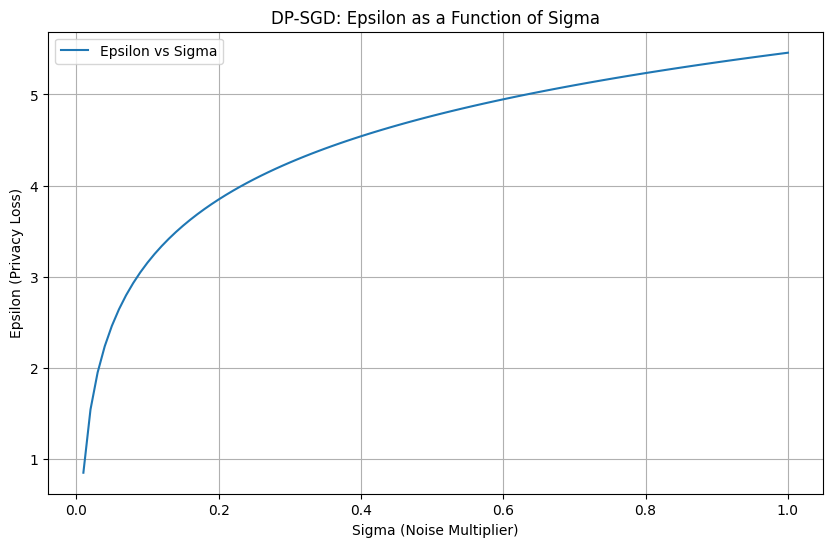

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the default values for DP-SGD hyperparameters are defined elsewhere,
# and only the value of σ (noise_multiplier) varies.

# Placeholder values for other DP-SGD hyperparameters
l2_norm_clip = 1.0
batch_size = 256
sample_size = 60000 # Assuming a dataset size of 60,000

# Function to calculate epsilon given sigma (noise_multiplier)
def calculate_epsilon(sigma):
    # This is a placeholder function.
    # In practice, this would involve more complex calculations, often using specific libraries
    # such as TensorFlow Privacy, which can compute epsilon for given hyperparameters.
    # Here, we'll use a simplified mock calculation.
    return np.log(sigma * sample_size / (l2_norm_clip * batch_size))

# Range of sigma values
sigmas = np.linspace(0.01, 1, 100)

# Calculate epsilon for each sigma
epsilons = [calculate_epsilon(sigma) for sigma in sigmas]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigmas, epsilons, label='Epsilon vs Sigma')
plt.xlabel('Sigma (Noise Multiplier)')
plt.ylabel('Epsilon (Privacy Loss)')
plt.title('DP-SGD: Epsilon as a Function of Sigma')
plt.legend()
plt.grid(True)
plt.show()


TODO: Run DP-SGD again with $\sigma=0.1$ and compare accuracy with the previous experiment.

In [ ]:
# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.1, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3024
Epoch 2 loss: 2.2993
Epoch 3 loss: 2.2829
Epoch 4 loss: 2.2332
Epoch 5 loss: 2.1748
Epoch 6 loss: 2.1081
Epoch 7 loss: 2.0467
Epoch 8 loss: 2.0142
Epoch 9 loss: 1.9891
Epoch 10 loss: 1.9633
Epoch 11 loss: 1.9356
Epoch 12 loss: 1.9067
Epoch 13 loss: 1.8787
Epoch 14 loss: 1.8517
Epoch 15 loss: 1.8228
Epoch 16 loss: 1.7934
Epoch 17 loss: 1.7622
Epoch 18 loss: 1.7289
Epoch 19 loss: 1.6941
Epoch 20 loss: 1.6551
Finished Training
Accuracy of the network on the train images: 47.16796875%


TODO:
How would privacy guarantee and model accuracy change when we increase the value of $\sigma$?

When we increase the value of $\sigma$, the privacy guarantee will get higher, since more noise has been added. However, the model accuarcy would drop, since the noise will effect the model to learn meaningful pattern from the data.

## Q3: System cost

TODO: Why is DP-SGD computation much slower than SGD?

TODO: For the naive SGD, if there are $P$ trainable parameters, we know that we need to store $P$ gradients during each batch iteration. How many gradients need to store for DP-SGD during each batch iteration?


P1

DP-SGD (Differential Privacy Stochastic Gradient Descent) is generally slower than standard SGD (Stochastic Gradient Descent) for several reasons:

Per-Sample Gradient Computation:

In standard SGD, gradients are computed once per batch, aggregating the data of all samples in the batch.
In contrast, DP-SGD requires computing gradients for each individual sample within a batch to apply differential privacy mechanisms properly. This significantly increases the computational workload.
Gradient Clipping and Noise Addition:

DP-SGD involves additional steps of clipping the gradients for each sample and adding noise to these gradients to ensure differential privacy.
These operations add computational overhead not present in standard SGD.
Complexity of Privacy Accounting:

DP-SGD often requires tracking and calculating the accumulated privacy budget (measured in terms of ϵ) over the training process. This privacy accounting, depending on the method used, can be computationally intensive.
Lack of Optimization in Certain Implementations:

While standard SGD has been heavily optimized in most deep learning frameworks, implementations of DP-SGD might not be as optimized due to its complexity and relatively less frequent use.

P2

In DP-SGD, the number of gradients to store during each batch iteration is significantly higher than in naive SGD:

Naive SGD:

Only one gradient per parameter is stored, aggregated over all samples in the batch.
If there are P trainable parameters, you store P gradients.

DP-SGD:

Gradients are computed and stored for each individual sample in the batch before aggregation.
If there are P trainable parameters and the batch size is B, you need to store B×P gradients.

This is because for each of the B samples, a separate gradient for each of the P parameters is computed and stored before clipping, noise addition, and aggregation.

The increased storage requirement for gradients in DP-SGD is another factor contributing to its higher computational cost compared to standard SGD. This requirement also emphasizes the need for efficient memory management when implementing DP-SGD, especially for large models and batch sizes.